<a href="https://colab.research.google.com/github/Voidmort/Study-Notes-TensorFlow/blob/master/TensorFlow_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: TensorFlow 3
date: 2018-12-29 15:10:00
tags: Tensorflow
categories: Tensorflow
---

# 使用TensorFlow的基本步骤

# 添加必要的库

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10  # 最大显示行数
pd.options.display.float_format = '{:.1f}'.format  # 精确度 保留一位小数


# 加载数据集

加载的数据集，数据基于加利福尼亚州1990年的人口普查数据

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

初始化数据集，对数据集进行随机化处理，以确保不会出现损害随机梯度下降的效果。此外，我们会将 `median_house_value` 调整为以千为单位，这样，模型就能够以常用范围内的学习速率较为轻松地学习这些数据。

In [0]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13098,-121.9,37.6,20.0,1309.0,184.0,514.0,172.0,11.0,475.8
6576,-118.3,34.1,52.0,1261.0,616.0,2309.0,581.0,1.6,225.0
12732,-121.8,37.7,17.0,3112.0,872.0,1392.0,680.0,3.0,172.5
6505,-118.3,34.0,34.0,1462.0,394.0,1310.0,351.0,1.2,90.1
339,-116.9,32.7,9.0,2652.0,393.0,1355.0,362.0,6.3,293.1
...,...,...,...,...,...,...,...,...,...
6741,-118.3,33.9,41.0,896.0,198.0,605.0,168.0,2.3,128.1
496,-117.0,33.7,13.0,16148.0,3474.0,6159.0,3232.0,2.0,97.8
9140,-119.0,35.4,30.0,227.0,75.0,169.0,101.0,1.4,60.0
2610,-117.7,34.1,33.0,2081.0,409.0,1008.0,375.0,2.6,138.1


# 检查数据

建议在使用数据之前，先对它有一个初步的了解。

输出关于各列的一些实用统计信息快速摘要：样本数，均值，标准偏差，最大值，最小值和各种分位数。

In [0]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


# 构建第一个模型

尝试预测median_house_value，它将是我们的标签，也称为目标。我们将使用total_rooms作为输入特征。

**注意**：我们使用的是城市街区级别的数据，因此该特征表示相应街区的房间总数。

为了训练模型，我们将使用 TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API 提供的 [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) 接口。此 API 负责处理大量低级别模型搭建工作，并会提供执行模型训练、评估和推理的便利方法。

## 第一步：定义特征并配置特征列

为了将我们的训练数据导入TensorFlow，我们需要指定每个特征包含的数据类型。在练习中，主要使用一下两类数据：

    分类数据： 一种文字数据。
    数值数据：一种数字（整数或浮点数）数据以及希望是为数字的数据。
    
在 TenssorFlow中，使用“特征列”的结构来表示特征的数据类型。特征列仅储存对特征数据的描述；不包含特征数据本身。

一开始，只使用一个数值输入特征total_rooms。以下代码会从 california_housing_dataframe 中提取 total_rooms 数据，并使用 numeric_column 定义特征列，这样会将其数据指定为数值：

In [0]:
# 定义输入特征 total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# 为total_rooms配置一个由数字构成的feature column
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

 **注意**：`total_rooms` 数据的形状是一维数组（每个街区的房间总数列表）。这是 `numeric_column` 的默认形状，因此我们不必将其作为参数传递。

## 第二步：定义目标

接下来，我们将定义目标，也就是 `median_house_value`。同样，我们可以从 `california_housing_dataframe` 中提取它：

In [0]:
# 定义目标
targets = california_housing_dataframe["median_house_value"]

## 第三步：配置LinearRegressor

 接下来，我们将使用 LinearRegressor 配置线性回归模型，并使用 `GradientDescentOptimizer`（它会实现小批量随机梯度下降法 (SGD)）训练该模型。`learning_rate` 参数可控制梯度步长的大小。

**注意**：为了安全起见，我们还会通过 `clip_gradients_by_norm` 将[梯度裁剪](https://developers.google.com/machine-learning/glossary/#gradient_clipping)应用到我们的优化器。梯度裁剪可确保梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降法失败。

In [0]:
# 使用梯度下降作为训练模型的优化器
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# 使用我们的特性列和优化器配置线性回归模型
# 为梯度下降设置0.0000001的学习率
linear_regresor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

## 第四步：定义输入函数

 要将加利福尼亚州住房数据导入 `LinearRegressor`，我们需要定义一个输入函数，让它告诉 TensorFlow 如何对数据进行预处理，以及在模型训练期间如何批处理、随机处理和重复数据。

首先，我们将 *Pandas* 特征数据转换成 NumPy 数组字典。然后，我们可以使用 TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) 根据我们的数据构建 Dataset 对象，并将数据拆分成大小为 `batch_size` 的多批数据，以按照指定周期数 (num_epochs) 进行重复。

**注意**：如果将默认值 `num_epochs=None` 传递到 `repeat()`，输入数据会无限期重复。

然后，如果 `shuffle` 设置为 `True`，则我们会对数据进行随机处理，以便数据在训练期间以随机方式传递到模型。`buffer_size` 参数会指定 `shuffle` 将从中随机抽样的数据集的大小。

最后，输入函数会为该数据集构建一个迭代器，并向 LinearRegressor 返回下一批数据。

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """训练一个特征的线性回归模型
    参数:
      features: pandas DataFrame 类型的 features
      targets: pandas DataFrame 类型的 targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. 是否随机化 data.
      num_epochs: 数据应重复的周期数. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
      元组：下一个数据批处理的(特征、标签/目标)
    """
  
    # 将pandas数据转换为numpy数组字典
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    # 构建dataset，并且拆分为batch_size个数据    
    ds = Dataset.from_tensor_slices((features, targets))  # 限制为最大2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

第五步：训练数据

 现在，我们可以在 `linear_regressor` 上调用 `train()` 来训练模型。我们会将 `my_input_fn` 封装在 `lambda` 中，以便可以将 `my_feature` 和 `target` 作为参数传入（有关详情，请参阅此 [TensorFlow 输入函数教程](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model)），首先，我们会训练 100 步。

In [0]:
_ = linear_regresor.train(
    input_fn = lambda: my_input_fn(my_feature, targets),
    steps=100
)

## 第六步： 评估模型

我们基于该训练数据做一次预测，看看我们的模型在训练期间与这些数据的拟合情况。

**注意**：训练误差可以衡量您的模型与训练数据的拟合情况，但并**_不能_**衡量模型**_泛化到新数据_**的效果。在后面的练习中，您将探索如何拆分数据以评估模型的泛化能力。

In [0]:
# 为预测创建一个输入函数
predication_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# 在 linear_regressor 上调用predict()进行预测
predictions = linear_regresor.predict(input_fn=predication_input_fn)

# 将预测格式化为一个NumPy的数组，这样我们就可以计算错误度量
predictions = np.array([item['predictions'][0] for item in predictions])

# 输出方差
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


如何判断误差有多大？
由于均方误差 (MSE) 很难解读，因此我们经常查看的是均方根误差 (RMSE)。RMSE 的一个很好的特性是，它可以在与原目标相同的规模下解读。

我们来比较一下 RMSE 与目标最大值和最小值的差值：

In [0]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


我们的误差跨越目标值近一般范围，为了进一步缩小误差，首先了解一下我们的预测predictions和targets的总体统计信息。



In [0]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


此信息也许有些帮助，比较看相差还是蛮大的，通过数据可视化来观察下

我们知道，单个特征的线性回归可以绘制一条将输入 x 映射到输出 y 的线。

首先，获得均匀分布的随机数据样本，以便绘制可辨识的散点图。

In [0]:
sample = california_housing_dataframe.sample(n=300)  # 随机抽样300个来观察

然后，根据模型的偏差项和特征权重绘制学习线，并绘制散点图。

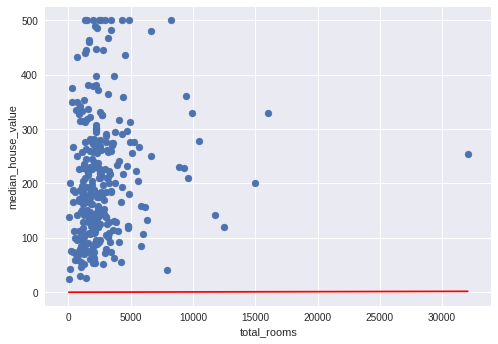

In [0]:
# 获取 total_rooms 最大与最小值
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# 检索训练过程中产生的最终权重和偏差
weight = linear_regresor.get_variable_value("linear/linear_model/total_rooms/weights")[0]
bias = linear_regresor.get_variable_value("linear/linear_model/bias_weights")

# 获取total_rooms预测的最小和最大值
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# 现在我们有两个坐标后 画出回归线
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# 写上每个轴代表的含义
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# 画出sample 数据的散点图
plt.scatter(sample["total_rooms"], sample["median_house_value"])

plt.show()


这条线看起来明显和目标相差很大，综上所述，这些初级健全性检查提示我们也许可以找到更好的线。

# 调整模型超参数

我们把以上所学的东西整理到一个函数中，以方便我们更容易的调整参数和观察变化。


In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """一个线性回归的训练模型
    参数：
        learning_rate: 学习速率 float
        steps: 训练总次数 int
        batch_size: 批处理大小 非0 int
        input_feature: 一个' string '，指定一个来自' california_housing_dataframe '的列用作输入特性。          
    """
    periods = 10  # 周期
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]
    
    # 创建 feature columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # 创建 input feature
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=True)
    
    # 创建 一个线性回归对象
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    # 设置回归线的状态
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    # 训练模型，但是在循环中这样做，这样我们就可以周期性地评估
    # 损失指标
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = [] 
    for period in range(0, periods):
        # 训练模型，从之前的状态开始
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # 计算预测值
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        # 计算损失
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        print("   period %02d : %0.2f" % (period, root_mean_squared_error))
        # 添加loss 到list
        root_mean_squared_errors.append(root_mean_squared_error)
        # 纪录权重和偏差
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    
    print("Model training finished.")
    
    # 输出一个周期内损失指标的图表。
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # 输出带有校准数据的表
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)  
    return calibration_data

设置参数初步训练下一试试

Training model...
RMSE (on training data):
   period 00 : 236.40
   period 01 : 235.26
   period 02 : 234.10
   period 03 : 232.96
   period 04 : 231.87
   period 05 : 230.78
   period 06 : 229.62
   period 07 : 228.54
   period 08 : 227.36
   period 09 : 226.38
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 226.38


,predictions,targets
0,9.7,66.9
1,10.6,80.1
2,7.0,85.7
3,13.6,73.4
4,14.0,65.5
...,...,...
16995,14.1,111.4
16996,7.5,79.0
16997,20.9,103.6
16998,12.6,85.8


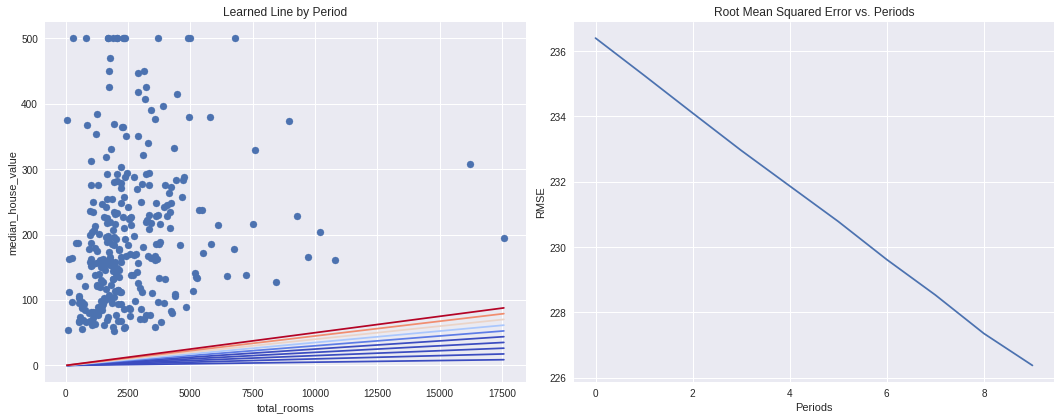

In [0]:
calibration_data = train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

差距还是蛮大的，改变参数试试

Training model...
RMSE (on training data):
   period 00 : 226.36
   period 01 : 216.00
   period 02 : 206.55
   period 03 : 198.01
   period 04 : 191.20
   period 05 : 185.74
   period 06 : 182.91
   period 07 : 179.02
   period 08 : 176.59
   period 09 : 175.67
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,115.8,207.3
std,95.5,116.0
min,0.1,15.0
25%,64.0,119.4
50%,93.2,180.4
75%,138.0,265.0
max,1661.6,500.0


Final RMSE (on training data): 175.67


,predictions,targets
0,110.0,66.9
1,51.7,80.1
2,144.4,85.7
3,79.7,73.4
4,77.4,65.5
...,...,...
16995,47.5,111.4
16996,138.7,79.0
16997,248.7,103.6
16998,117.8,85.8


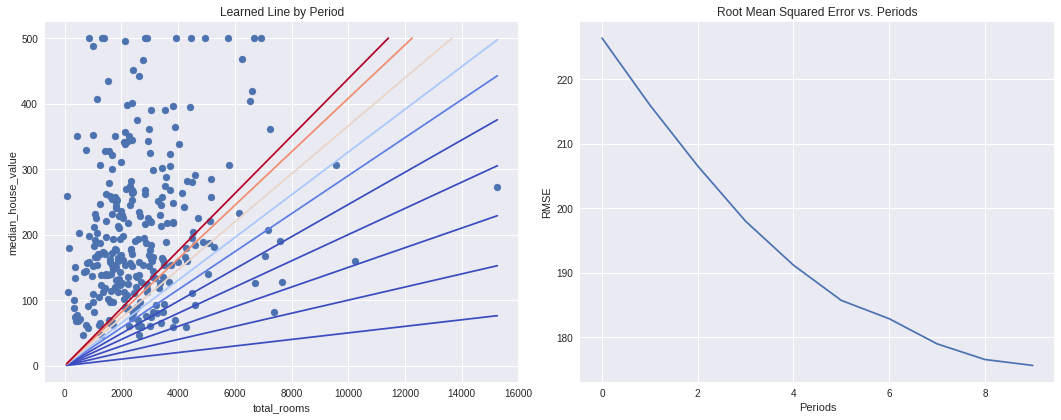

In [0]:
calibration_data = train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

 ## 有适用于模型调整的标准启发法吗？

降低RMSE，这是一个常见的问题。简短的答案是，不同超参数的效果取决于数据。因此，不存在必须遵循的规则，您需要对自己的数据进行测试。

即便如此，我们仍在下面列出了几条可为您提供指导的经验法则：

 * 训练误差应该稳步减小，刚开始是急剧减小，最终应随着训练收敛达到平稳状态。
 * 如果训练尚未收敛，尝试运行更长的时间。
 * 如果训练误差减小速度过慢，则提高学习速率也许有助于加快其减小速度。
   * 但有时如果学习速率过高，训练误差的减小速度反而会变慢。
 * 如果训练误差变化很大，尝试降低学习速率。
   * 较低的学习速率和较大的步数/较大的批量大小通常是不错的组合。
 * 批量大小过小也会导致不稳定情况。不妨先尝试 100 或 1000 等较大的值，然后逐渐减小值的大小，直到出现性能降低的情况。

重申一下，切勿严格遵循这些经验法则，因为效果取决于数据。请始终进行试验和验证。

## 尝试其他特征

使用 `population` 特征替换 `total_rooms` 特征，看看能否取得更好的效果。

Training model...
RMSE (on training data):
   period 00 : 225.40
   period 01 : 214.37
   period 02 : 204.42
   period 03 : 195.76
   period 04 : 188.29
   period 05 : 182.98
   period 06 : 178.93
   period 07 : 175.94
   period 08 : 174.97
   period 09 : 175.14
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,120.1,207.3
std,96.4,116.0
min,0.3,15.0
25%,66.4,119.4
50%,98.0,180.4
75%,144.6,265.0
max,2997.3,500.0


Final RMSE (on training data): 175.14


,predictions,targets
0,116.6,66.9
1,829.3,80.1
2,97.7,85.7
3,136.3,73.4
4,41.7,65.5
...,...,...
16995,56.4,111.4
16996,12.3,79.0
16997,83.9,103.6
16998,84.3,85.8


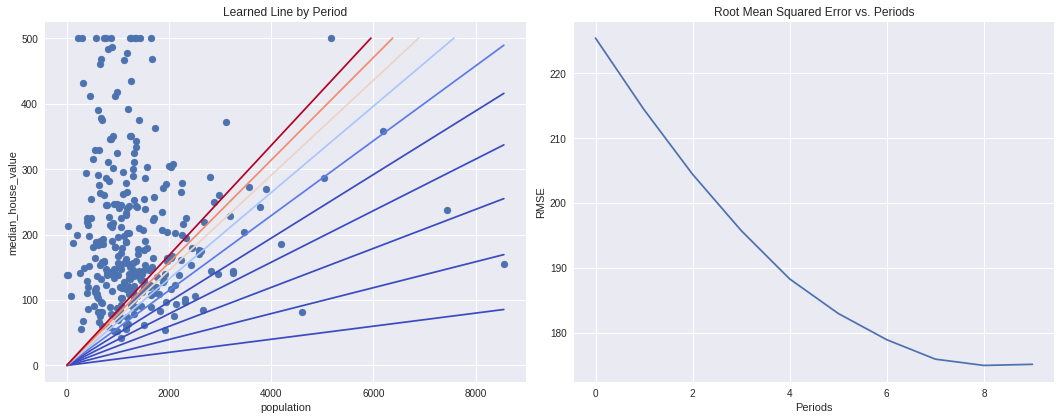

In [0]:
calibration_data = train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)

# 合成特征和离群值

## 尝试合成特征


`total_rooms` 和 `population` 特征都会统计指定街区的相关总计数据。

但是，如果一个街区比另一个街区的人口更密集，会怎么样？我们可以创建一个合成特征（即 `total_rooms` 与 `population` 的比例）来探索街区人口密度与房屋价值中位数之间的关系。

在以下单元格中，创建一个名为 `rooms_per_person` 的特征，并将其用作 `train_model()` 的 `input_feature`。

通过调整学习速率，您使用这一特征可以获得的最佳效果是什么？（效果越好，回归线与数据的拟合度就越高，最终 RMSE 也会越低。）

Training model...
RMSE (on training data):
   period 00 : 214.75
   period 01 : 193.24
   period 02 : 176.45
   period 03 : 160.89
   period 04 : 150.13
   period 05 : 146.30
   period 06 : 145.44
   period 07 : 146.13
   period 08 : 147.65
   period 09 : 149.22
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,200.9,207.3
std,93.2,116.0
min,44.5,15.0
25%,164.4,119.4
50%,197.8,180.4
75%,226.2,265.0
max,4443.7,500.0


Final RMSE (on training data): 149.22


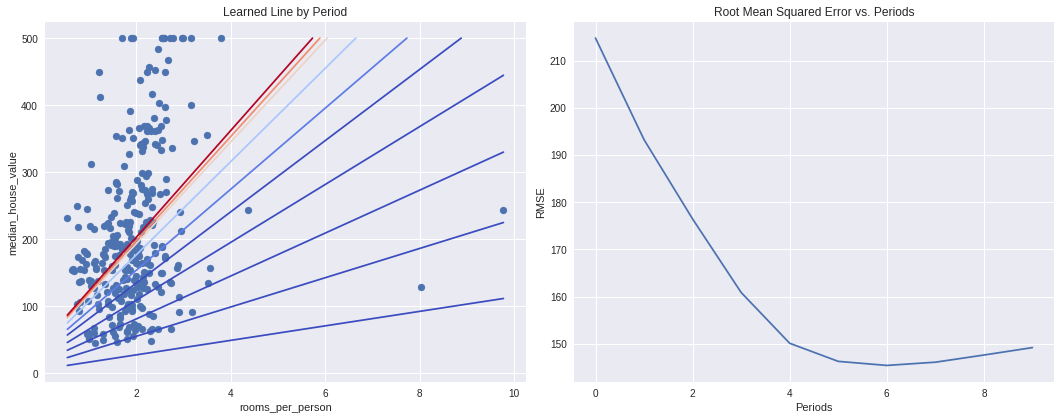

In [0]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

## 识别离群值

通过创建预测值与目标值的散点图来可视化模型效果。理想情况下，这些值将位于一条完全相关的对角线上。

使用您在任务 1 中训练过的人均房间数模型，并使用 Pyplot 的 `scatter()` 创建预测值与目标值的散点图。

您是否看到任何异常情况？通过查看 `rooms_per_person` 中值的分布情况，将这些异常情况追溯到源数据。

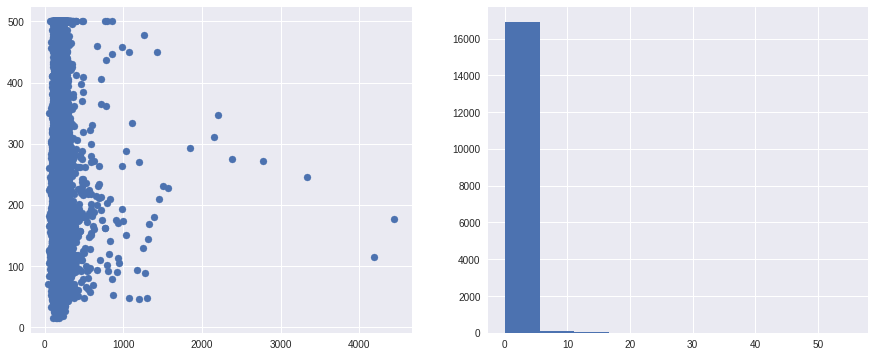

In [0]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

 校准数据显示，大多数散点与一条线对齐。这条线几乎是垂直的，我们稍后再讲解。现在，我们重点关注偏离这条线的点。我们注意到这些点的数量相对较少。

观察我们绘制 `rooms_per_person` 的直方图，则会发现我们的输入数据中有少量离群值

## 截取离群值

将 `rooms_per_person` 的离群值设置为相对合理的最小值或最大值来进一步改进模型拟合情况。

以下是一个如何将函数应用于 Pandas `Series` 的简单示例，供您参考：

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

上述 `clipped_feature` 没有小于 `0` 的值。

观察直方图发现大多数数值都小于5，我们将`rooms_per_person` 的值截取为5，然后绘制直方图再次检查结果。

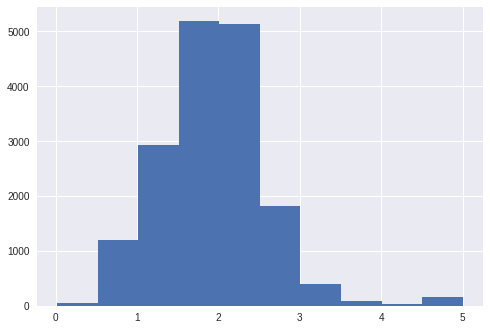

In [0]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

验证截取是否有效，我们再训练一次模型，并再次输出校准数据：

Training model...
RMSE (on training data):
   period 00 : 214.33
   period 01 : 192.43
   period 02 : 172.30
   period 03 : 155.07
   period 04 : 142.01
   period 05 : 134.29
   period 06 : 129.31
   period 07 : 128.99
   period 08 : 127.60
   period 09 : 126.94
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,189.5,207.3
std,49.3,116.0
min,45.1,15.0
25%,158.1,119.4
50%,189.6,180.4
75%,216.4,265.0
max,419.5,500.0


Final RMSE (on training data): 126.94


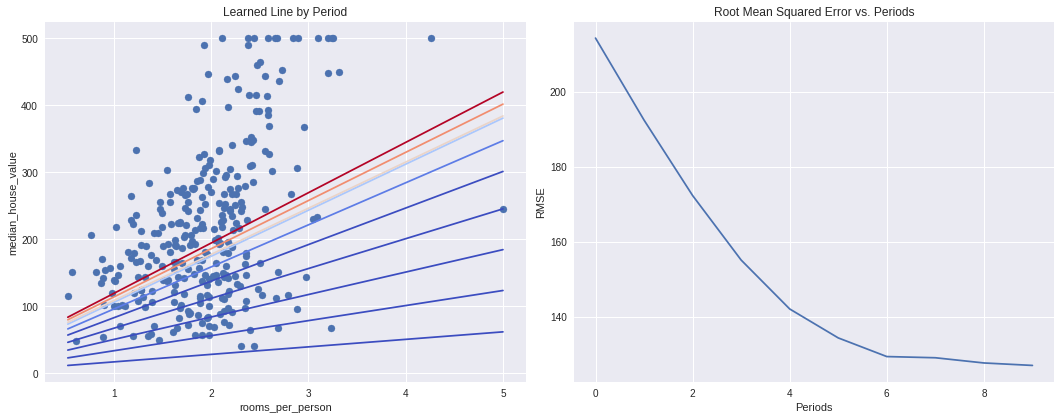

In [0]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

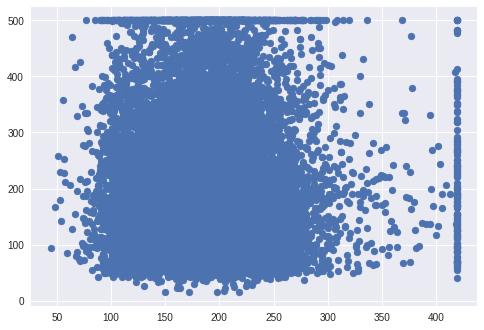

In [0]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])